In [62]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt


from data_loader import DataLoader

plt.style.use("plotstyle.mplstyle")
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Dataset

In [2]:
# Deutsche uni

# Dataset Information
# 
# Frame rate: 16 FPS
#
# Person id | frame | x pos | y pos | z pos




Create a DataLoader object and pass a path to the file you want to load. If you like to copy the data from an existing object pass None. You can pass "txt", "csv" files.

with the ds.load() method you can actually load the data into the object

In [63]:


FPS = 16

BG = "Datasets/UG/ug.png"

PATH_1 = "Datasets/UG/UG-roh_nachkorrigiert/ug-180-095.txt"

#PATH_1 = "test.hd5"
#PATH_1 = "test.csv"

ds = DataLoader(PATH_1)
ds.load()

print("Persons: ", ds.data.p.max())
print("Frame maximum :", ds.data.f.max() )

loaded 364 persons
Persons:  364
Frame maximum : 3770


# Person and Velocities

Use the method ds.person to get the trajectory of a given person

<IPython.core.display.Javascript object>


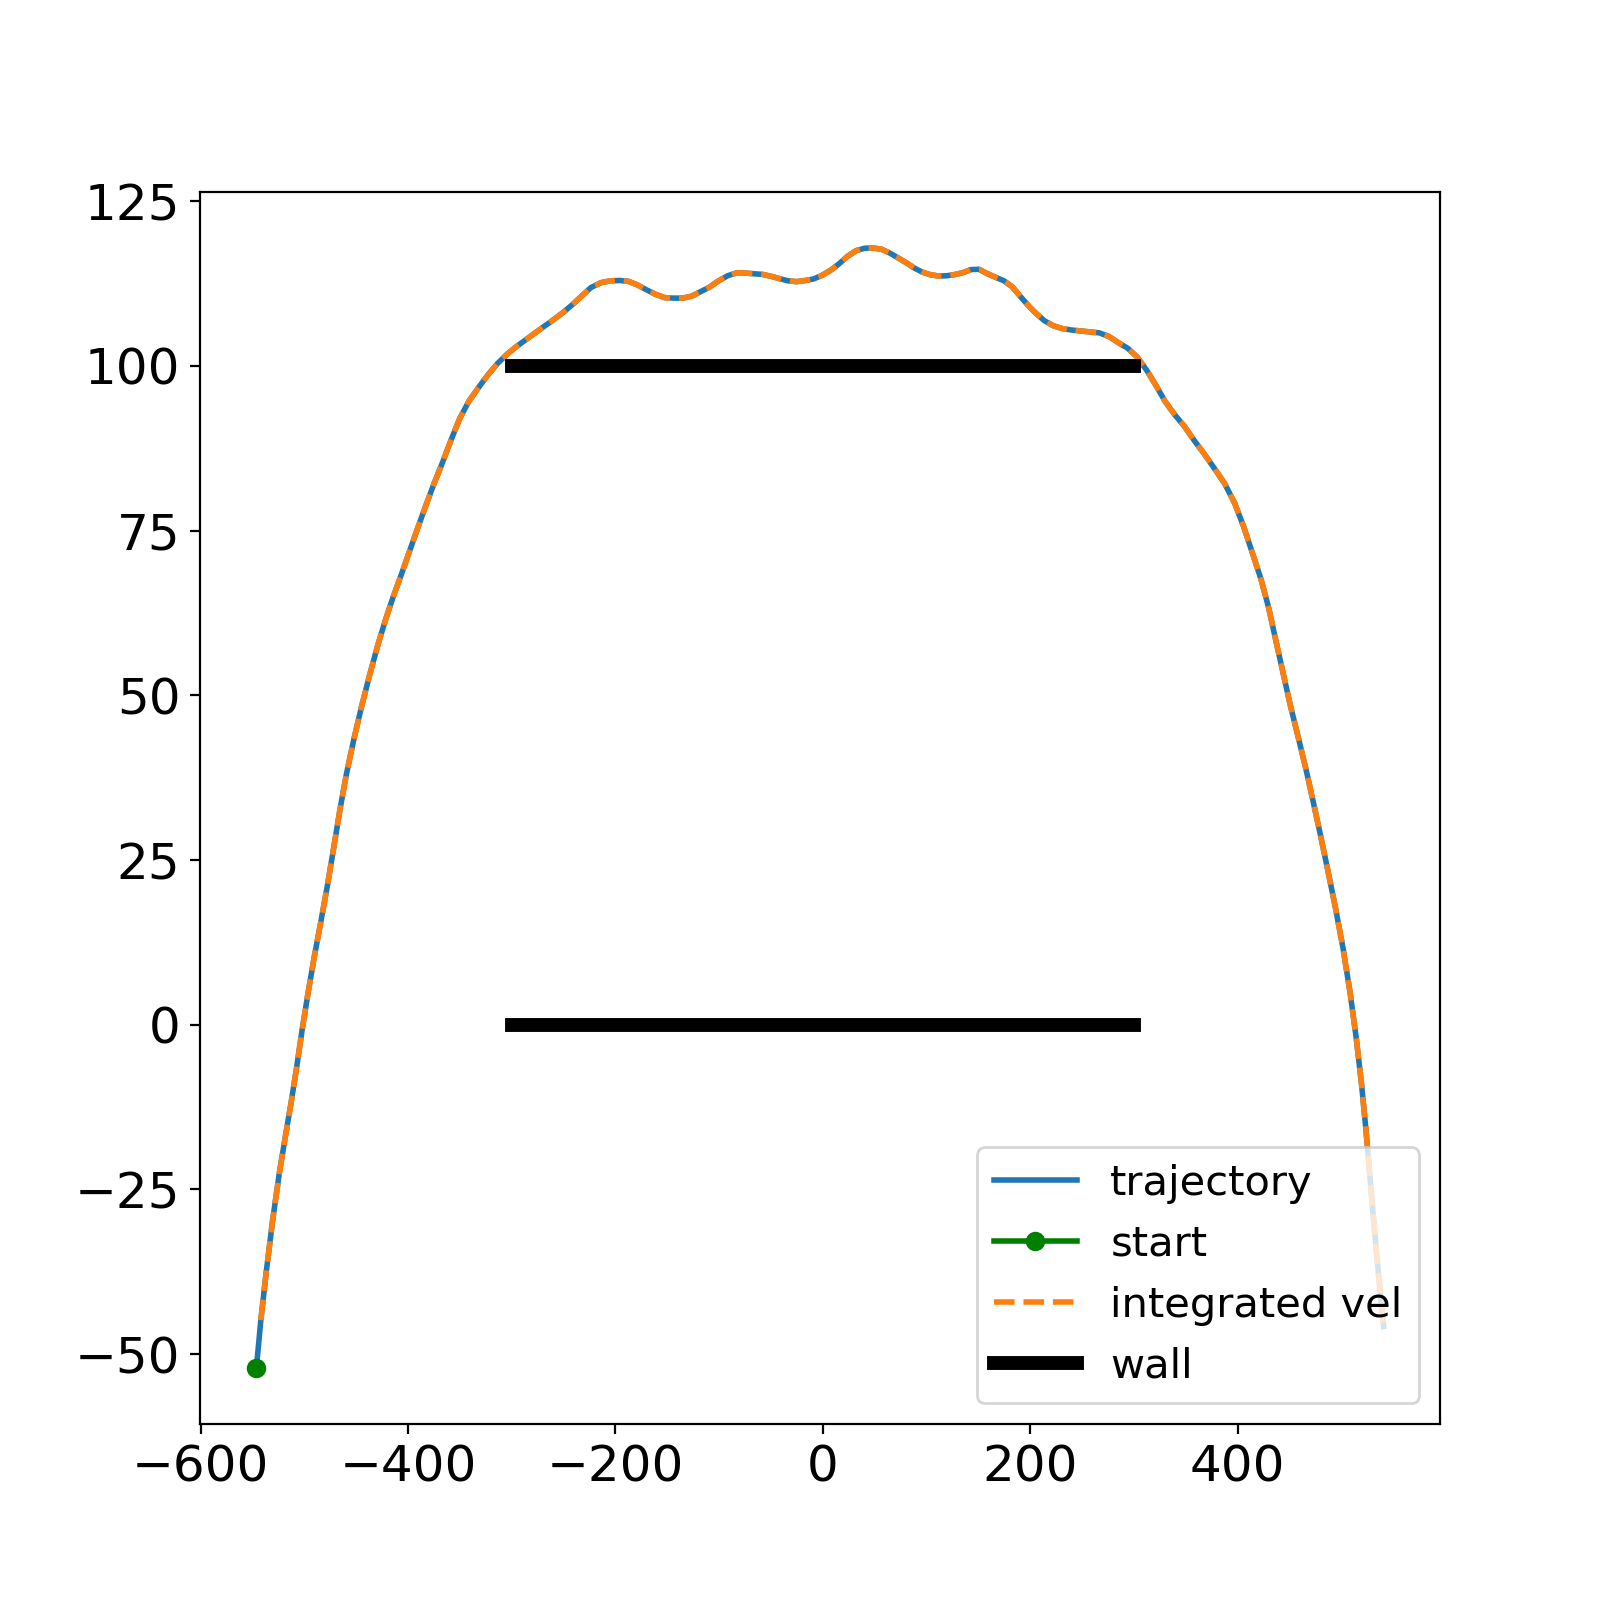

364

In [64]:
fps = ds.fps
idx, _, pers = ds.person(11, with_id=True)

T = 1/fps

x0, y0, _, _ = pers[0]

plt.figure(figsize=(8, 8))

plt.plot(pers[:,0], pers[:,1], label="trajectory")
plt.plot(pers[0,0], pers[0,1], c="g", marker="o", label="start")



sx = np.cumsum(pers[:,2]) * T + x0
sy = np.cumsum(pers[:,3]) * T + y0
plt.plot(sx, sy, ls="--", label="integrated vel")


#plt.xlim([-300, 300])
#plt.ylim([0, 100])
plt.plot([-300, 300], [100, 100], c="k", lw="5", label="wall")
plt.plot([-300, 300], [0, 0], c="k", lw="5")
plt.legend(loc = 4)
plt.show()


ds.data.p.max()



# Frame and nearest neighbors

with ds.frame you can get all persons on the fram

use ds.fram_nn to get the nearest neighbors of person with given id.

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


<IPython.core.display.Javascript object>


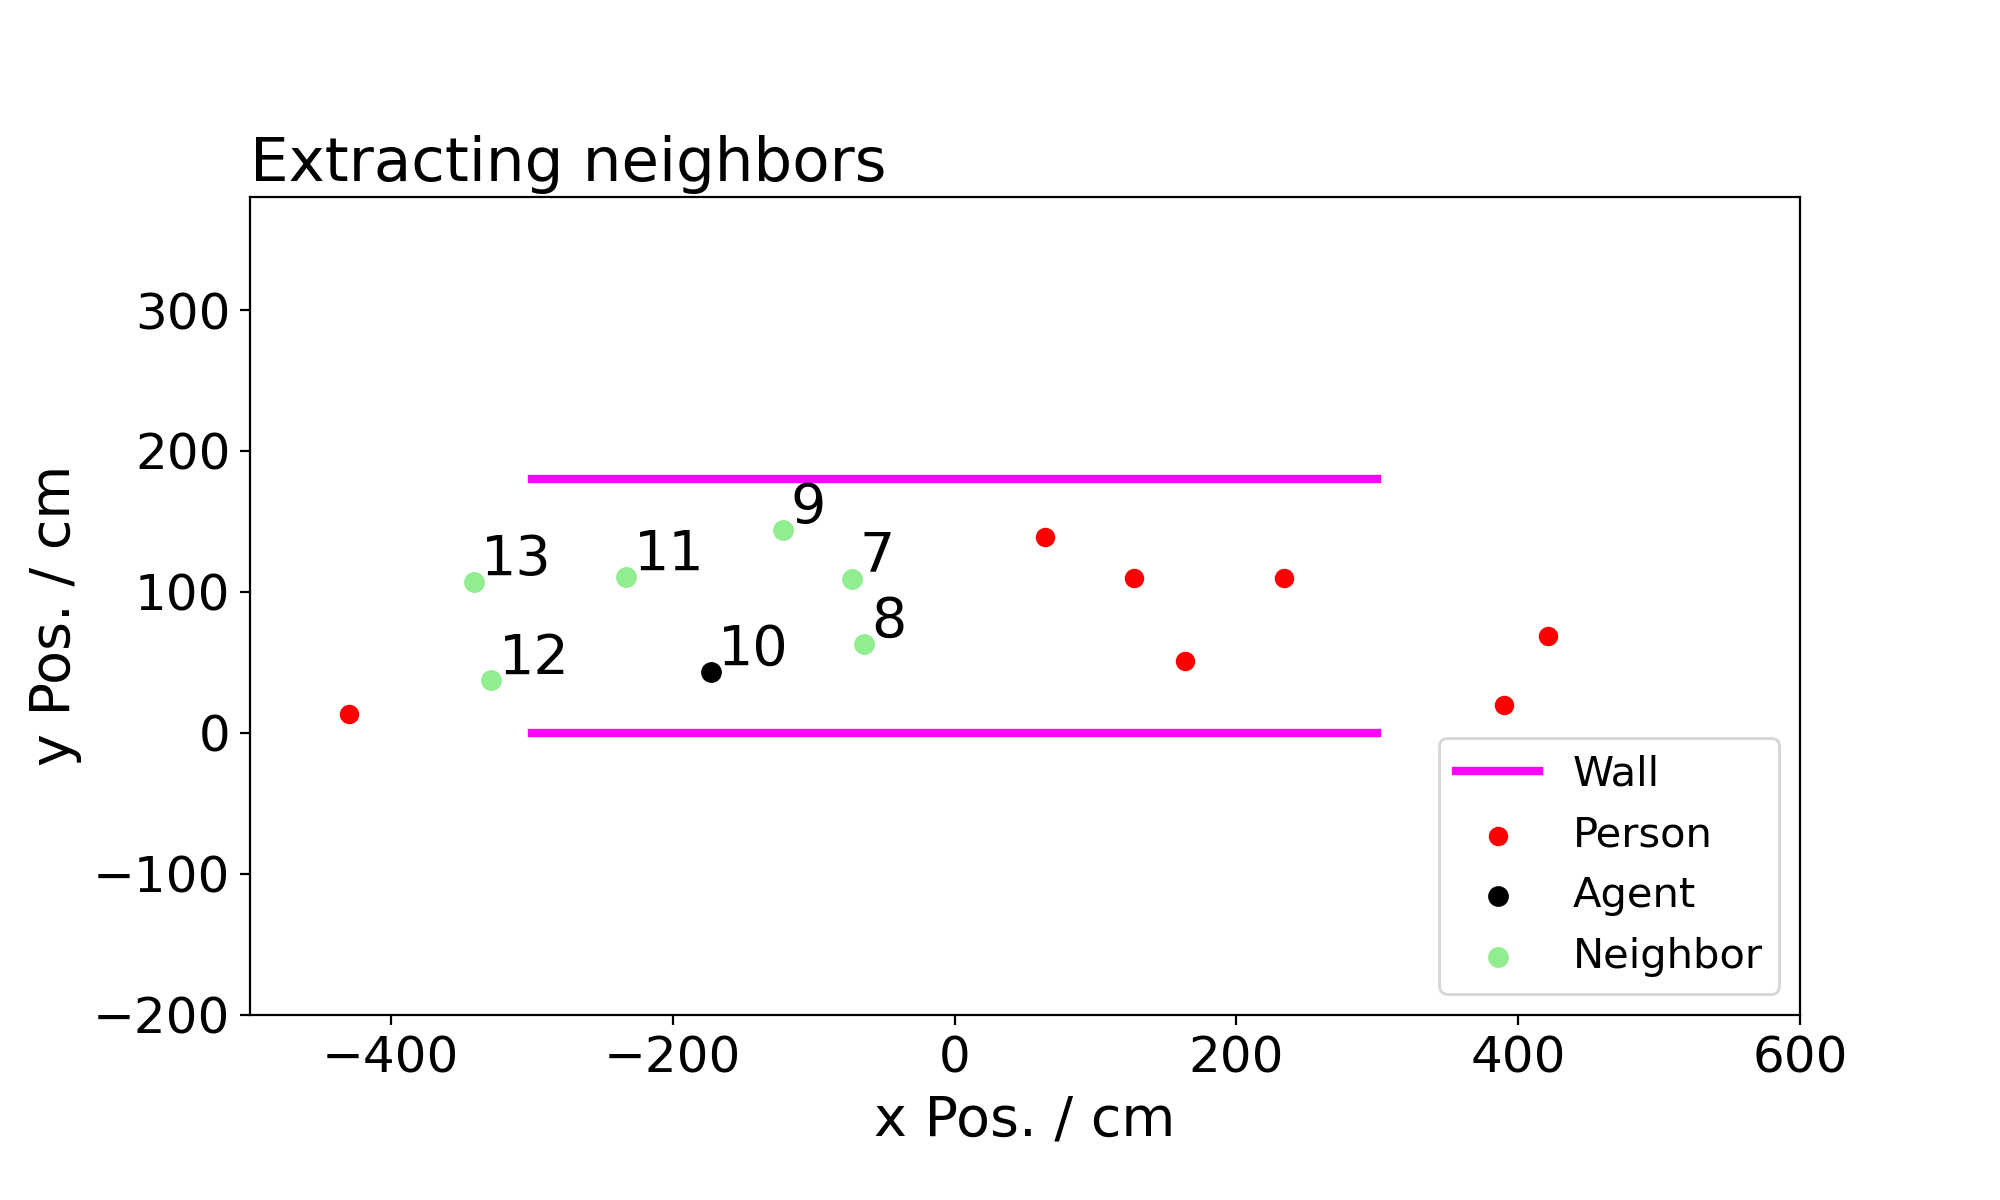

Filled:  False
[10 11  8  9  7 12 13]
[[-173.159    43.0047  103.776    17.9792]
 [-232.854   110.553   148.608    21.52  ]
 [ -63.9654   63.0918  124.7376   10.4272]
 [-121.511   143.966   132.032     2.304 ]
 [ -72.7933  109.465   130.8176    8.592 ]
 [-328.669    37.2312  123.84     45.416 ]
 [-341.132   107.077   142.048    23.2   ]]


In [81]:
f_id = 100
person_id = 10
neighbors = 6

idx, p_id, pos_vel = ds.frame(f_id, with_id=True)
print(p_id)

plt.figure(figsize = (10,6))
plt.scatter(pos_vel[:,0],pos_vel[:,1], c="red", label="Person")

#for i, txt in enumerate(p_id):
#    plt.annotate(txt, (pos_vel[i,0], pos_vel[i,1]))

p_id, pos_vel = ds.grab_roi(p_id, pos_vel, box=((-300, 180), (300,0)))

#plt.scatter(pos_vel[:,0],pos_vel[:,1], c="b", )



#plt.show()

# input of this function is an array of type [[x, y, ...], ...]
#p_id_nn, pos_vel_nn = ds.get_nn(p_id, pos_vel, 0, nn=6, fill=True, include_origin=True)



# We directly get an the nearest neighbors for a given person id and a frame
i, p_id_nn, pos_vel_nn, filled = ds.frame_nn(f_id, person_id, nn=neighbors,
                                  fill=True,
                                  mode="wrap",
                                  use_roi=True,
                                  box=((-300, 180), (300,0)),
                                  include_origin=True,
                                  ret_full=True)


print("Filled: ", filled)

#plt.scatter(pos_vel_nn[:,0],pos_vel_nn[:,1], c="b", label="Person in ROI")

for i, txt in enumerate(p_id_nn):
    plt.annotate(txt, (pos_vel_nn[i,0]+5, pos_vel_nn[i,1]+5),  )

for i, (l, pos) in enumerate(zip(p_id_nn, pos_vel_nn)):
    
    c = 'lightgreen' if i>0 else 'black'
    t = 'Neighbor' if i>0 else 'Agent'
    if i<2:
        plt.scatter(pos[0],pos[1], marker='.', linewidth=2, s=120,  ec=c,  fc=c, label=t)
    else:
        plt.scatter(pos[0],pos[1], marker='.', linewidth=2, s=120,  ec=c, fc=c )
    
#plt.xlim([-300, 300])
#plt.ylim([-500, 100])
plt.plot([-300, 300], [180, 180], c="fuchsia", lw="3", label="Wall")
plt.plot([-300, 300], [0, 0], c="fuchsia", lw="3")

ax1 = plt.gca()
ax1.set_aspect('equal', adjustable='box')
ax1.set_xlabel('x Pos. / cm')
ax1.set_ylabel('y Pos. / cm ')
ax1.set_title("Extracting neighbors", loc="left")
plt.legend(loc = 4)
plt.ylim([-200, 380])
plt.xlim([-500, 600])
#plt.suptitle("Extracting neighbors")
plt.savefig("data/Output/extracting_neighbros.pdf")
plt.show()

print(p_id_nn)
print(pos_vel_nn)

# Extract Trajectories

get all trajectories of persons through the corridor

In [66]:
idexs, trajs = ds.get_trajectories(nn=4, mode="zero")

print("loaded {} trajectories".format(len(idexs)))

100% (364 of 364) |######################| Elapsed Time: 0:03:06 Time:  0:03:06


loaded 364 trajectories


<IPython.core.display.Javascript object>


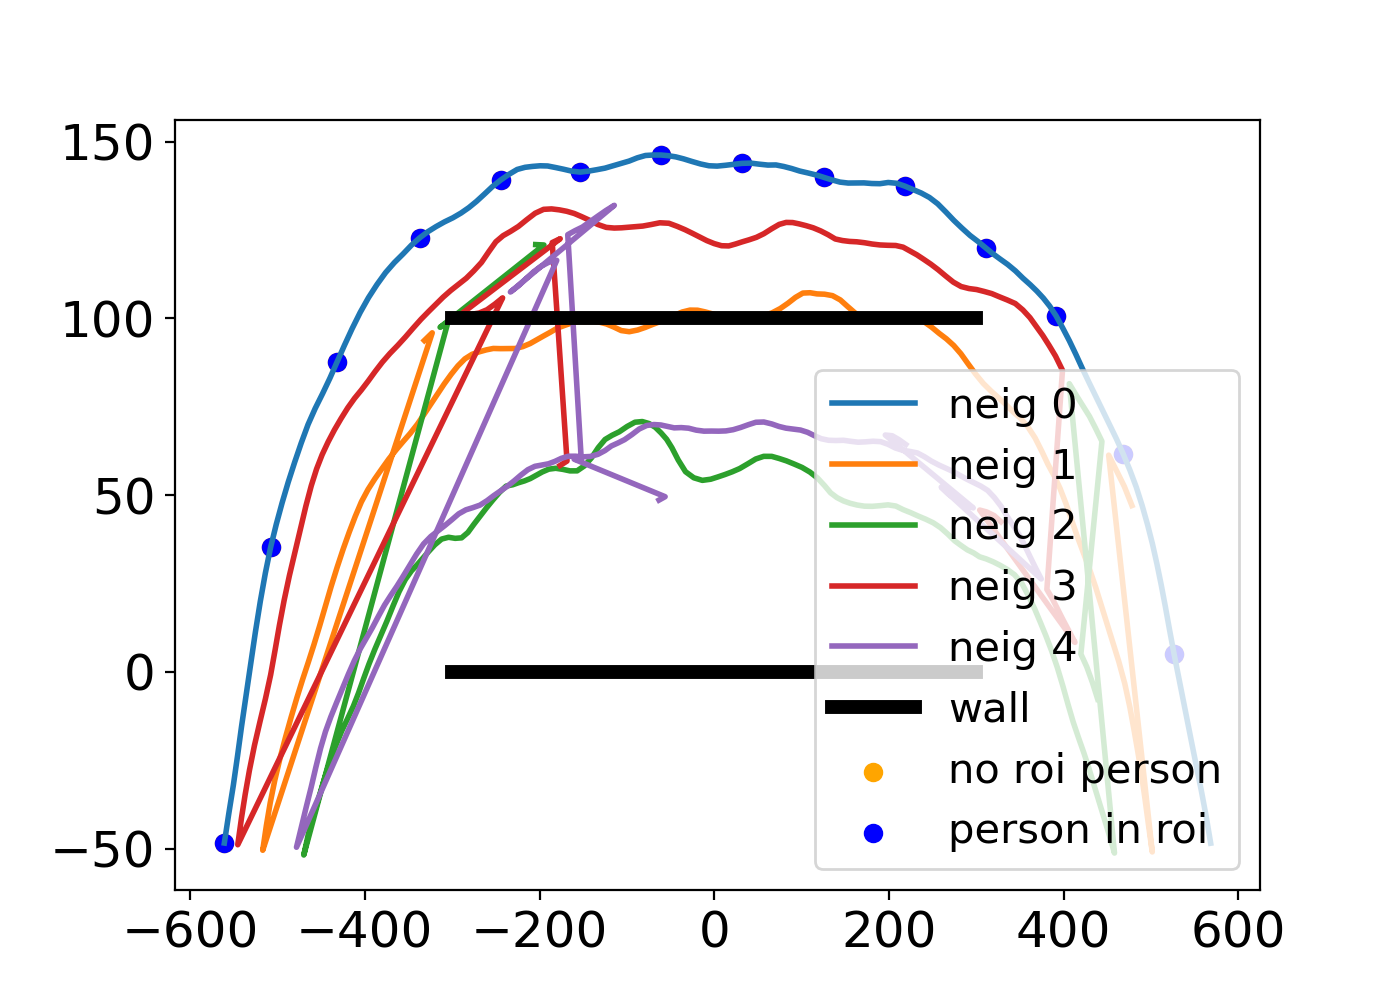

In [80]:
m = 20

ds.graph_traj(idexs[m], trajs[m])

In [68]:
steps_in, steps_truth = ds.trajectory_2_steps(trajs)
print(steps_in.shape)

(152390, 20)


Get training, validation and testing data as a tuple of input and truth values. You can use augmentation functions as a prameter.

In [72]:
# define a data augmentation function
f_x = ds.flip_x

In [73]:
train, val, test = ds.get_train_data(4, augmentation=[f_x], mode="wrap")

t = len(train[0])
v = len(val[0])
l = len(test[0])
s = t+v+l

print("We created {:.4}% Train, {:.4}% Validation, {:.4}% Test data".format(100*t/s, 100*v/s, 100*l/s))


loaded 22 trajectories
with augmentation 44 trajectories
3386 3386
extracted 3386 steps
We created 59.98% Train, 19.99% Validation, 20.02% Test data


# Data Object Testing



Get trajectory of Person 1 and modify it. We can append or replace the data. 
Use remove to delete from dataset

In [20]:
id = 1

frames, pos = ds.person(id)

In [21]:
pos -= [0, 10, 0, 0]

In [22]:
ds.append_person(23, frames, pos[:,:2], vel=pos[:,2:])

In [ ]:
ds.replace_person(1, frames, pos[:,:2], vel=pos[:,2:])

In [ ]:
ds.data

In [ ]:
ds.remove_person(23)

In [ ]:
_, t1 = ds.person(1)
_, t2 = ds.person(23)

plt.figure()
plt.plot(t1[:,1],t1[:,2])
plt.plot(t2[:,1],t2[:,2])
plt.plot([67, 67], [0, 170])
plt.show()


In [ ]:
ds.persons

In [60]:
ds.save("test")

# Create copy of data object
We create a copy of the data object and delete most of the person data.

In [64]:
ab = DataLoader(None)

In [65]:
ab.copy(ds)

In [66]:
for i in range(3, ab.persons):
    ab.remove_person(i)

In [68]:
print(ab.persons)
ab.data

3


,p,f,y,x,z,vx,vy
0,2.0,0,49.6503,-304.356,155.043,10.288,-10.1200
1,2.0,1,49.0178,-303.713,155.043,10.880,-7.5120
2,2.0,2,48.5483,-303.033,155.043,7.504,-7.6528
3,2.0,3,48.0700,-302.564,155.043,3.184,-6.4240
4,2.0,4,47.6685,-302.365,155.043,7.488,-4.8064
...,...,...,...,...,...,...,...
3217,1.0,106,-179.0100,518.204,0.000,23.648,-121.8080
3218,1.0,107,-186.6230,519.682,0.000,15.808,-125.2640
3219,1.0,108,-194.4520,520.670,0.000,20.288,-135.3280
3220,1.0,109,-202.9100,521.938,0.000,28.416,-147.3600


# All person Trajectories

<IPython.core.display.Javascript object>


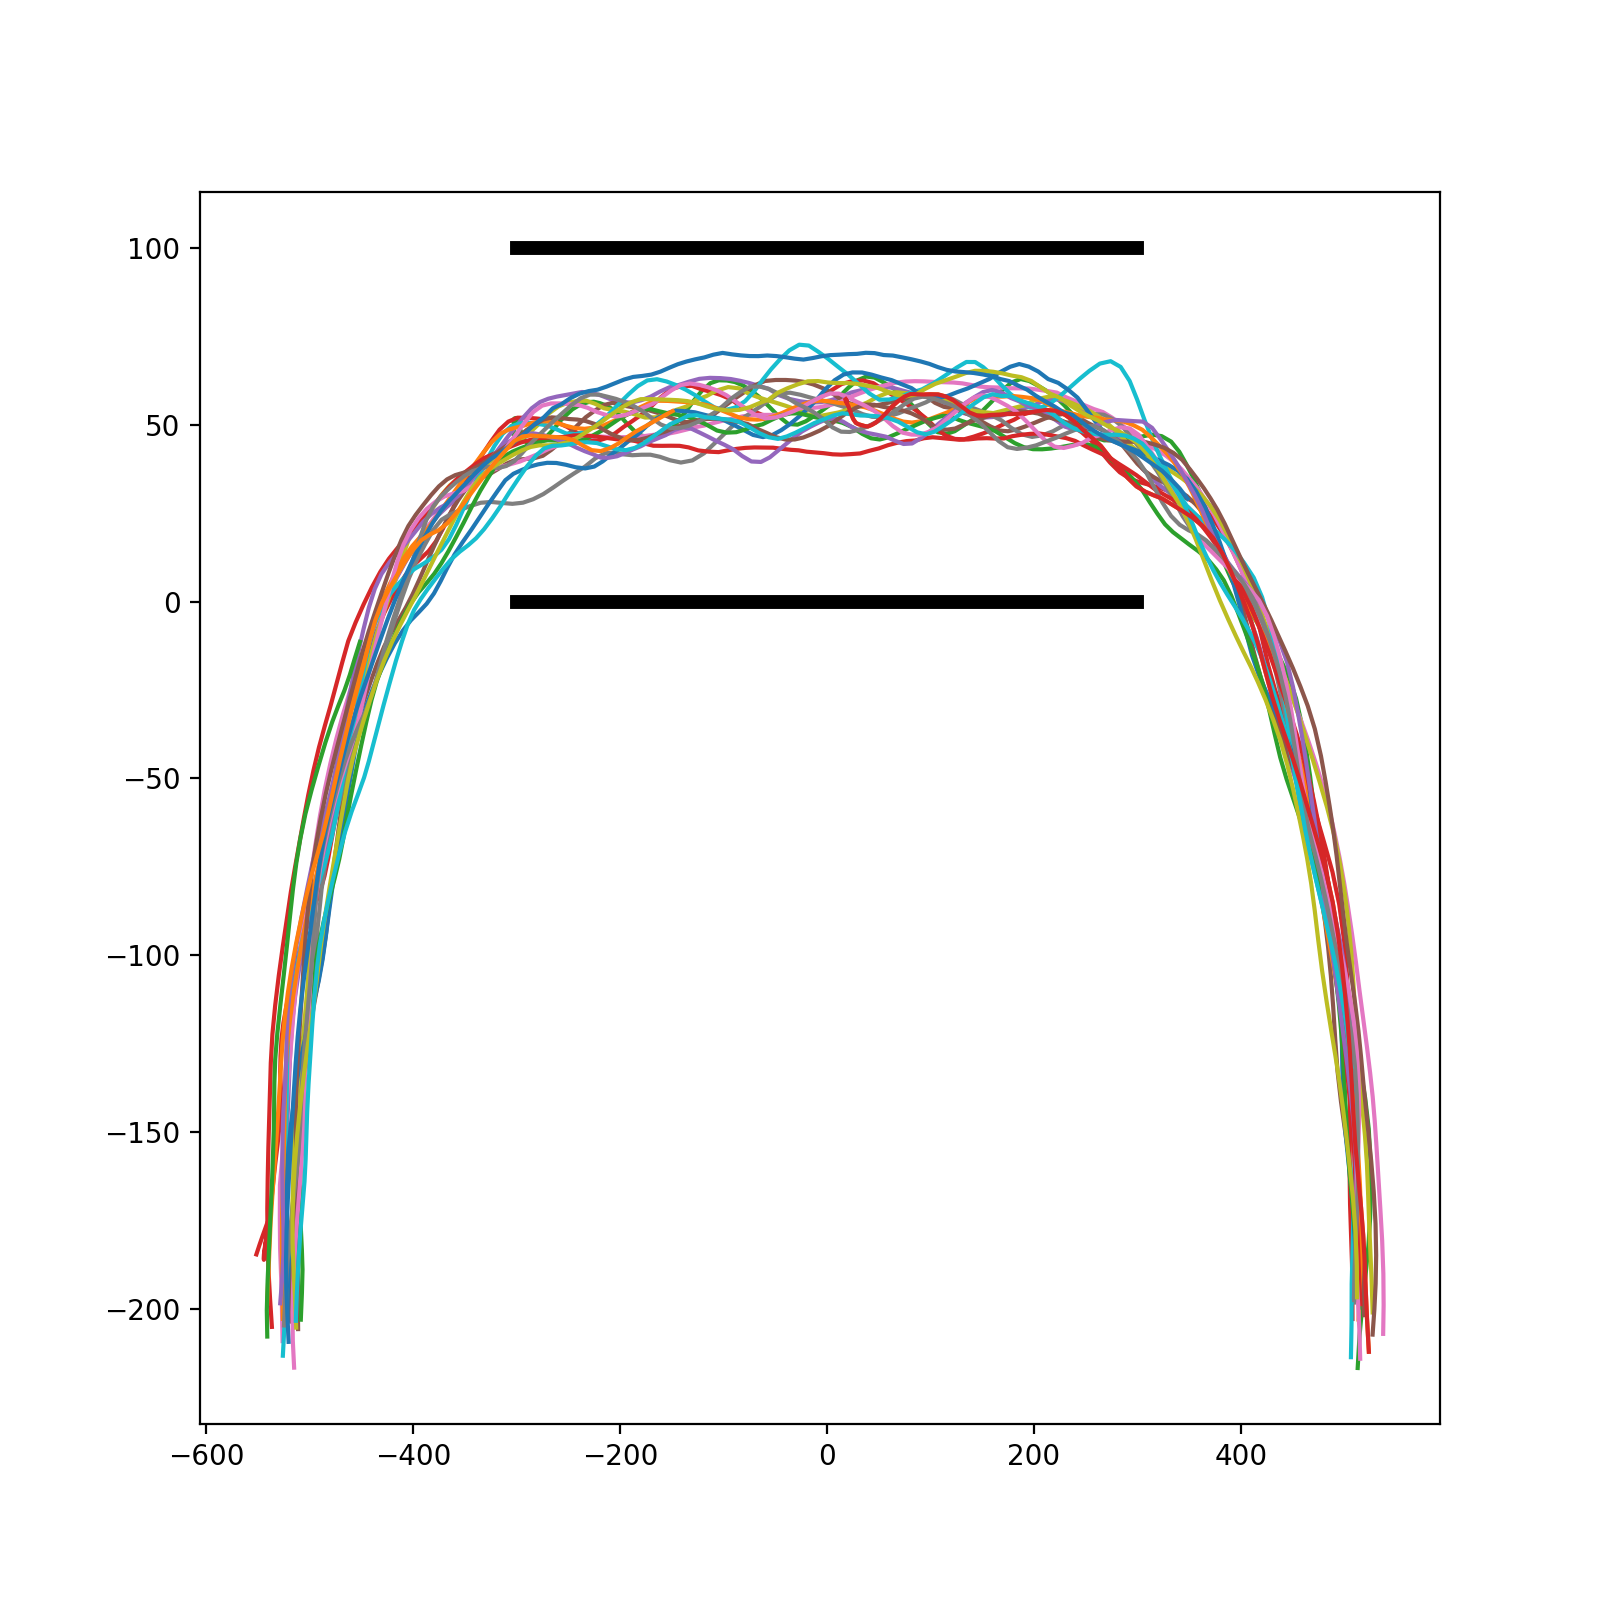

In [62]:
plt.figure(figsize=(8, 8))



plt.plot([-300, 300], [100, 100], c="k", lw="5")
plt.plot([-300, 300], [0, 0], c="k", lw="5")

for id in range(45):

    time, traj = ds.person(id)
    plt.plot(traj[:, 0], traj[:, 1])


#plt.xlim([-300, 300])
#plt.ylim([0, 100])
plt.show()

# Problem geometry

<IPython.core.display.Javascript object>


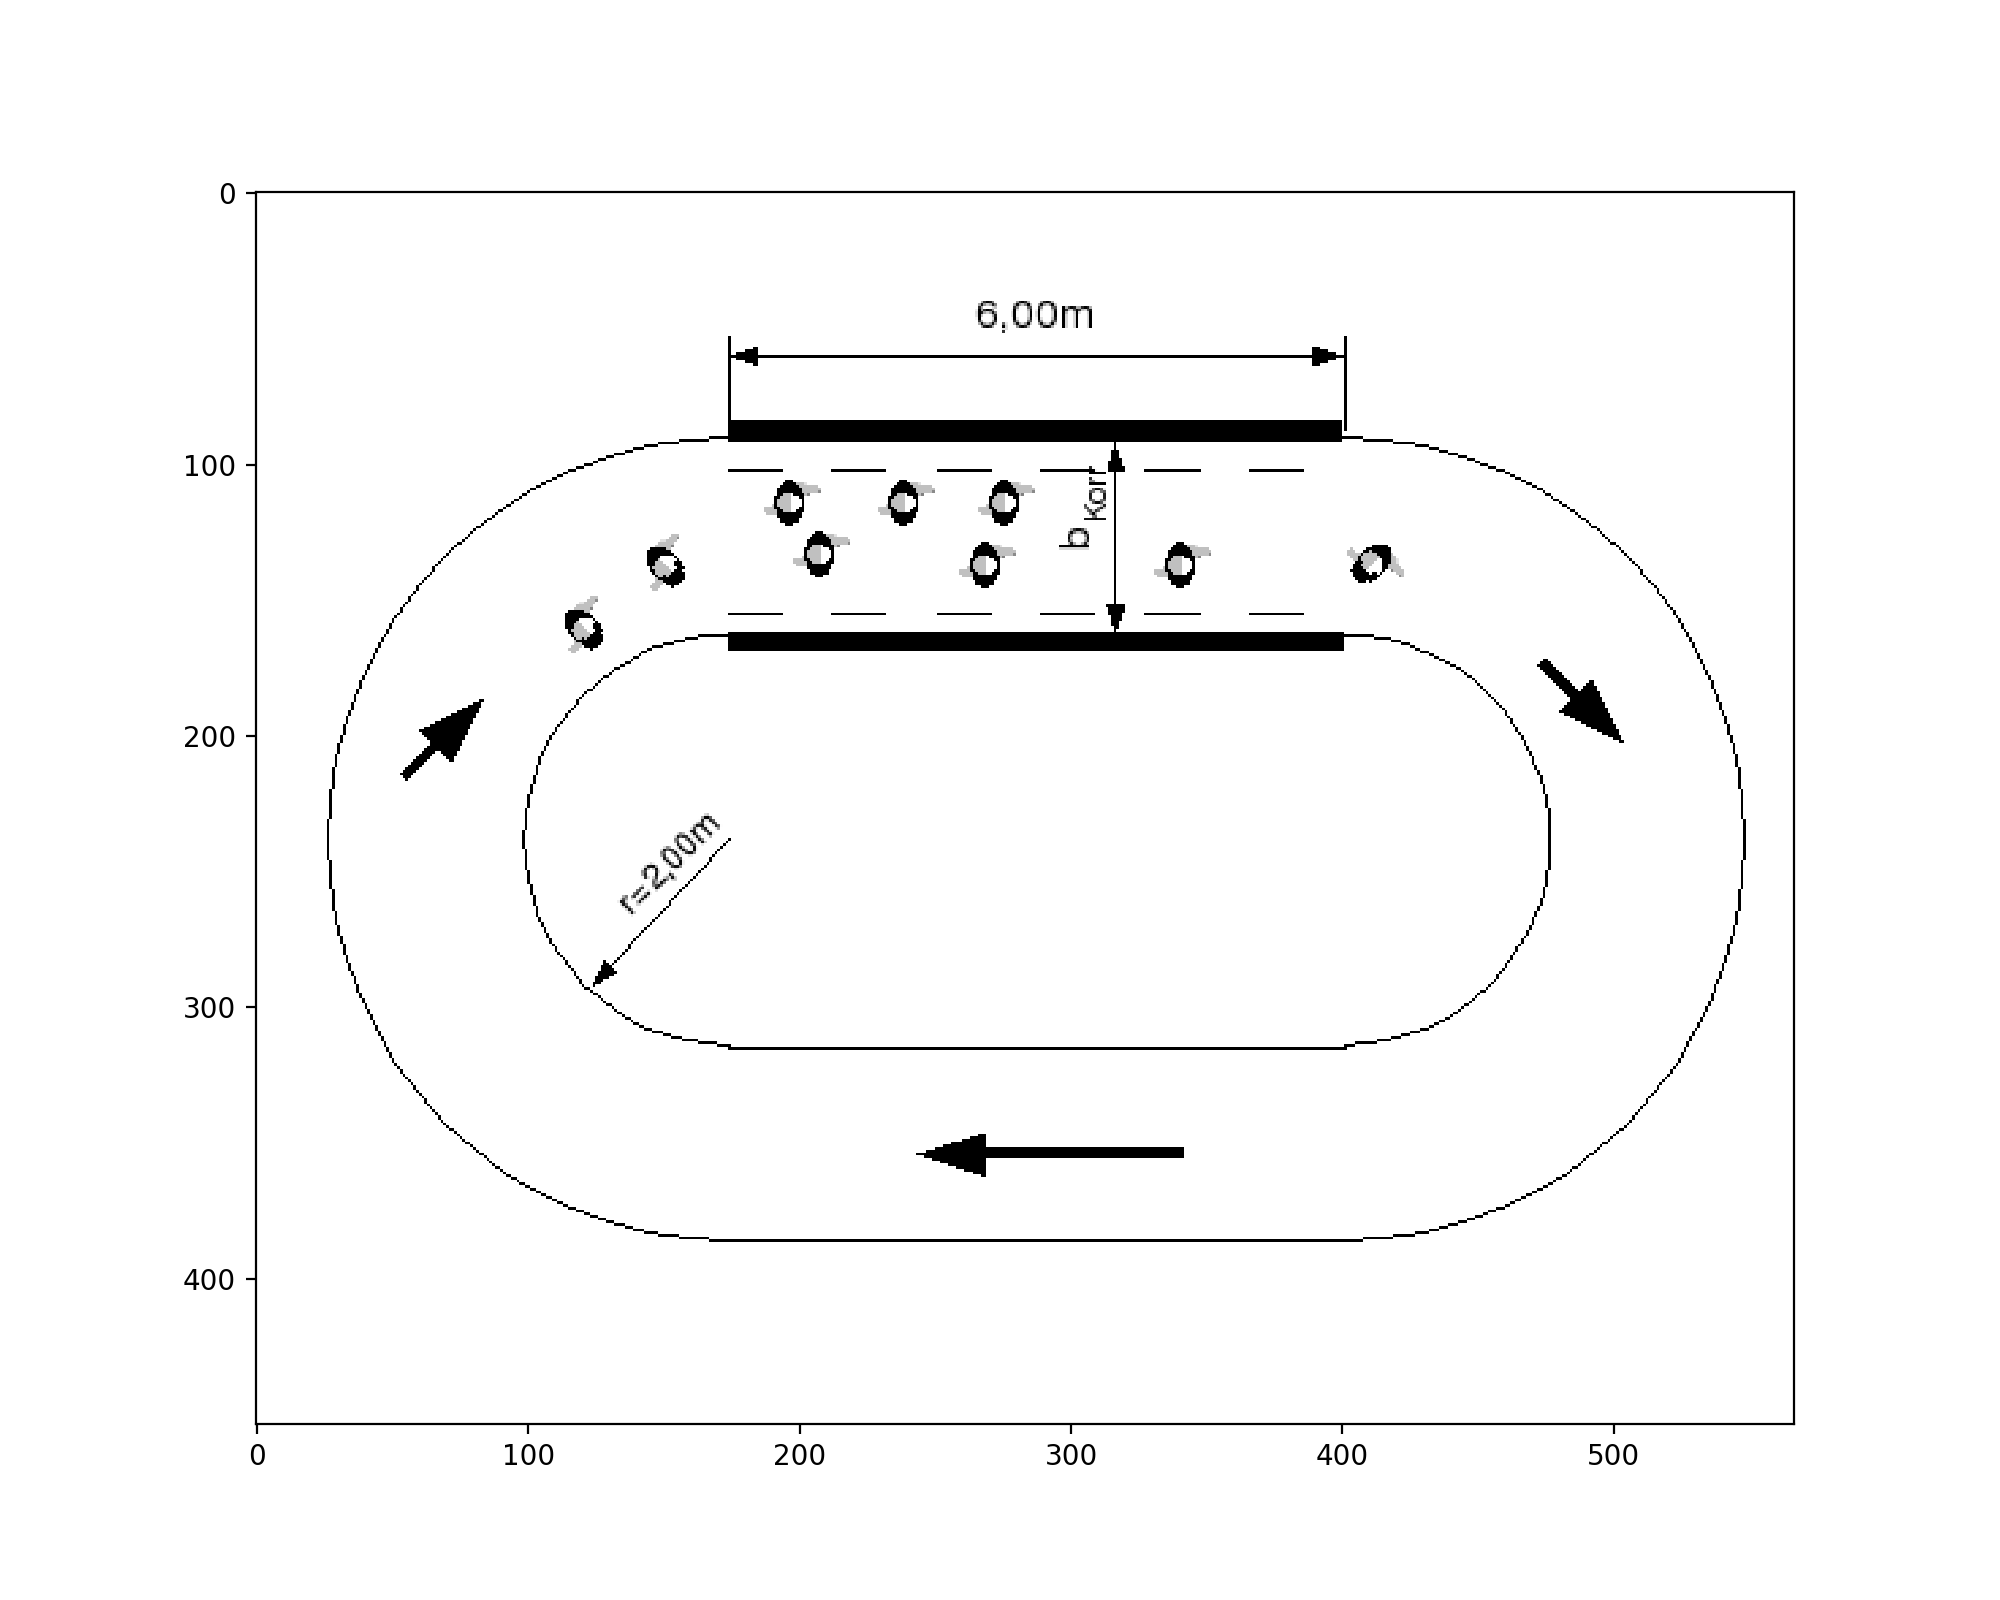

In [63]:
img = plt.imread(BG)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.show()